In [43]:
# DAY--1
# setting up the Environment 
!python --version


Python 3.12.7


In [5]:
pip install torch


Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install matplotlib


In [8]:
import torch
import torchvision

In [9]:
import torch
print(torch.__version__)


2.3.1+cpu


In [10]:
import torchvision
print(torchvision.__version__)


0.18.1+cpu


In [11]:
#Loading MNIST Dataset
train_data_set=torchvision.datasets.MNIST(root='./data', train=True, download=True )
# Load the MNIST test dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True)


In [12]:
print(train_data_set)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test


In [13]:
# DAY--2

In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [15]:
#different pre-processing steps 
transform = transforms.Compose([
    transforms.Resize((28, 28)),          # Resize image to 32x32
    transforms.RandomHorizontalFlip(),    # Randomly flip the images horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  #Randomly changes the brightness, contrast
    transforms.ToTensor(),                # Converts images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to range [-1, 1]
])


In [16]:
# Loading the MNIST training dataset
train_data_set=datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Loading the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Creating DataLoader for the training dataset
train_loader = DataLoader(dataset=train_data_set, batch_size=64, shuffle=True)
# Create DataLoader for the test dataset
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [17]:
data_iter = iter(train_loader)  #Creating the iterator
images, labels = next(data_iter) #to retrieve the next batch of images and labels from the iterator


In [18]:
# Function to display the images(Data Visualisation)
def show_img(images,labels):
    fig,axes=plt.subplots(4,5,figsize=(12,12))
    for i, axi in enumerate(axes.flatten()):
        axi.imshow(images[i].squeeze(), cmap='gray')
        axi.set_title("Label: "+str(labels[i].item()))
    plt.show()


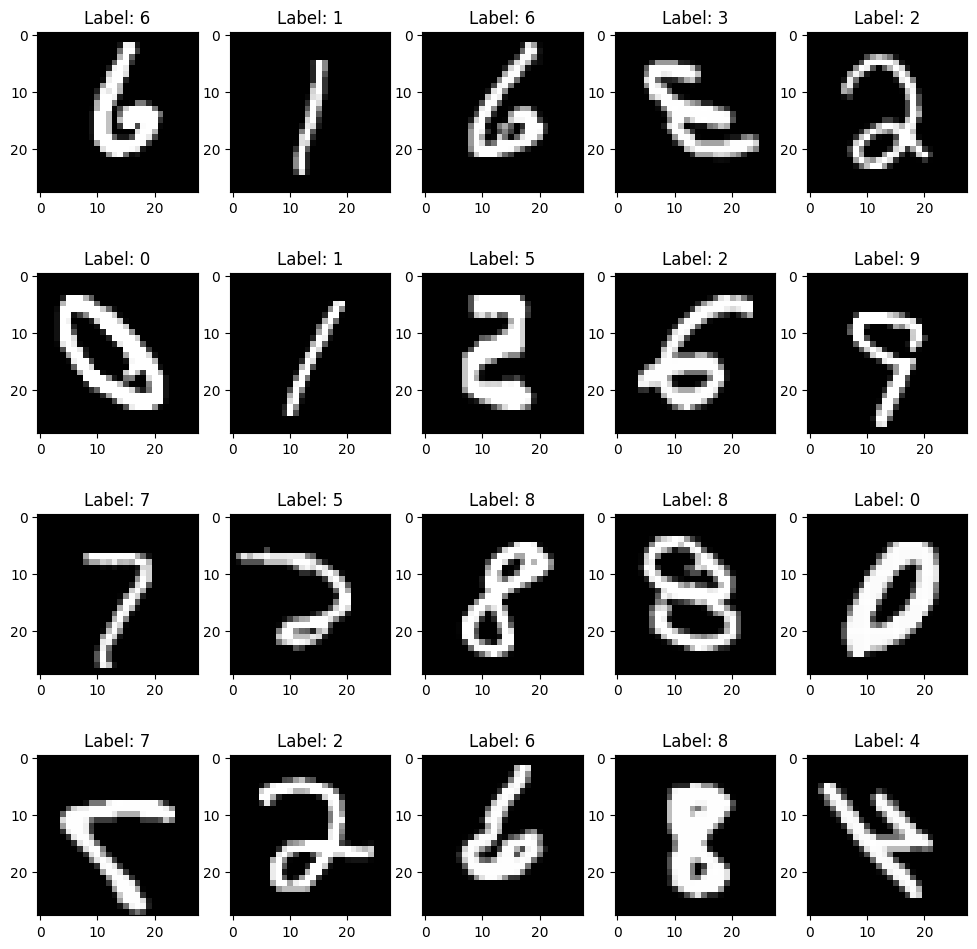

In [19]:
#Displaying the output
show_img(images,labels)

In [20]:
#Week 2

In [21]:
# Importing necessary modules
import torch.nn as nn
import torch.optim as optim
import torchmetrics
from sklearn.metrics import confusion_matrix

In [22]:
# Defining the MLP Model and the fully connected layers
class MLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=512, output_size=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) #Fully connected linear layer connecting input layer and hidden layer
        self.relu = nn.ReLU() #Activation function ReLU as no squashing of input range
        self.fc2 = nn.Linear(hidden_size, output_size) #Fully connected linear layer connecting hidden layer and output layer
        
    #Forward pass to define flow of data through layers
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flattening the 2D image to a 1D vector
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [23]:
# Model, Loss Function and optimizer initializer
model = MLP()
criterion = nn.CrossEntropyLoss() #Cross Entropy due to Multi Class Function
optimizer = optim.Adam(model.parameters(), lr=0.0009)  # Adam optimizer due to minimal tuning of hyperparameters

In [25]:
num_epochs = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        # Move data to device (CPU/GPU)
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        total_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/2], Loss: 0.1890, Accuracy: 94.13%
Epoch [2/2], Loss: 0.1619, Accuracy: 95.02%


In [26]:

# Defining the function to evaluate the MLP model
def evaluate_model(model, data_loader, dataset_type):
    model.eval()
    all_predictions = []  # List to store all predictions
    all_labels = []       # List to store all true labels

    with torch.no_grad():  # Disable gradient computation
        for images, labels in data_loader:
            # Move images and labels to the appropriate device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class labels
            
            all_predictions.append(predicted)
            all_labels.append(labels)

    # Concatenate all predictions and labels
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)

    # Initialize evaluation metrics
    accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=10)
    precision_metric = torchmetrics.Precision(task='multiclass', num_classes=10, average='macro')
    recall_metric = torchmetrics.Recall(task='multiclass', num_classes=10, average='macro')

    # Calculate overall accuracy, precision, recall
    accuracy = accuracy_metric(all_predictions, all_labels)
    precision = precision_metric(all_predictions, all_labels)
    recall = recall_metric(all_predictions, all_labels)

    # Print results
    print(f'{dataset_type} Accuracy: {accuracy * 100:.2f}%')
    print(f'{dataset_type} Precision: {precision * 100:.2f}%')
    print(f'{dataset_type} Recall: {recall * 100:.2f}%')

# Call evaluation function
evaluate_model(model, train_loader, "Train")
evaluate_model(model, test_loader, "Test")

Train Accuracy: 93.92%
Train Precision: 94.39%
Train Recall: 93.79%
Test Accuracy: 93.39%
Test Precision: 93.97%
Test Recall: 93.19%


In [ ]:
#CNN Model 

In [27]:
# Defining the CNN Model and the layers
class CNN(nn.Module):
    def __init__(self, num_classes = 10):
        super(CNN, self).__init__()
        self.conv = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 1) #Convolutional Layer to create feature map preserving spatial dimensions
        self.relu1 = nn.ReLU() #Activation function ReLU as no squashing of input range
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2) # Max pooling Layer; reducing spatial dimensions by half
        self.fc1 = nn.Linear(64 * 13 * 13, 128) # Fully connected input layer based on output of pooling layer
        self.relu2 = nn.ReLU() #Activation function ReLU as no squashing of input range
        self.fc2 = nn.Linear(128, 10) #Output Layer for classification
        
    #Forward pass to define flow of data through layers
    def forward(self, x):
        x = self.conv(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flattening the 2D image to a 1D vector for fully connected layer
        x = self.fc1(x)
        x = self.relu2(x)
        x = self.fc2(x)
        return x

In [28]:
model = CNN()
criterion = nn.CrossEntropyLoss() #Cross Entropy due to Multi Class Function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer due to minimal tuning of hyperparameters

In [30]:
num_epochs = 3 
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()  # Clearing of gradients before backward pass
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Loss Calculations
        loss.backward()  # Backward pass
        optimizer.step()  # Updating weights based on gradients
        total_loss += loss.item()  # Accumulation of the loss

    avg_loss = total_loss / len(train_loader)  # Calculation of the average loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.2f}')

Epoch [1/3], Loss: 0.23
Epoch [2/3], Loss: 0.14
Epoch [3/3], Loss: 0.10


In [ ]:
# training and testing of the model

In [ ]:
def evaluate_model(model, data_loader, dataset_type):
    model.eval()
    pred = [] #empty list to store all predictions by model
    truelabels = [] #empty list to store all labels from dataloader
    with torch.no_grad(): #to disable gradient computation to save memory 
        for images, labels in data_loader:
            outputs = model (images)
            _, predicted = torch.max(outputs.data, 1) #To get the predicted class labels from the model outputs
            pred.append(predicted)
            truelabels.append(labels)
    # Concatenation of all predictions and labels
    pred = torch.cat(pred)
    truelabels = torch.cat(truelabels)
    # Initializing evaluation metric
    accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=10)
    precision_metric = torchmetrics.Precision(task='multiclass', num_classes=10, average='macro')
    recall_metric = torchmetrics.Recall(task='multiclass', num_classes=10, average='macro')
    # Calculation of the overall accuracy, precision, recall of MLP
    accuracy = accuracy_metric(pred, truelabels)
    precision = precision_metric(pred, truelabels)
    recall = recall_metric(pred, truelabels)
    # Printing Results
    print(f'{dataset_type} Accuracy: {accuracy * 100:.2f}%')
    print(f'{dataset_type} Precision: {precision* 100:.2f}%')
    print(f'{dataset_type} Recall: {recall* 100:.2f}%')

# Call evaluation function
evaluate_model(model, train_loader, "Train")
evaluate_model(model, test_loader, "Test")

Train Accuracy: 98.98%
Train Precision: 98.98%
Train Recall: 98.96%
Test Accuracy: 97.65%
Test Precision: 97.67%
Test Recall: 97.60%


In [ ]:
pip install torchmetrics scikit-learn


   ---------------------------------------- 0.0/926.4 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.4 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.4 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.4 kB ? eta -:--:--
   --------------------- ---------------- 524.3/926.4 kB 578.7 kB/s eta 0:00:01
   --------------------- ---------------- 524.3/926.4 kB 578.7 kB/s eta 0:00:01
   -------------------------------- ----- 786.4/926.4 kB 524.3 kB/s eta 0:00:01
   -------------------------------- ----- 786.4/926.4 kB 524.3 kB/s eta 0:00:01
   -------------------------------------- 926.4/926.4 kB 500.2 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# implementation of confusion_matrix and classification report using sklearn 


Train Confusion Matrix:
 [[5880    0    0    4    2    8   13    2    7    7]
 [   1 6617   22   20    5   12    5   33   17   10]
 [   9   10 5598   73    4  114   65   29   48    8]
 [   2    2   14 5976    0   97    1   13   19    7]
 [   5    4   12    0 5692    0    9   22   11   87]
 [   3    1    7   41    0 5327   18   15    6    3]
 [  22    1    9    2   12   86 5783    1    2    0]
 [   4    2   10   19    9   16    1 6168   11   25]
 [   8    3   16   46    3   55    7   22 5648   43]
 [  14    0    3   37   14   27    2   70   11 5771]]


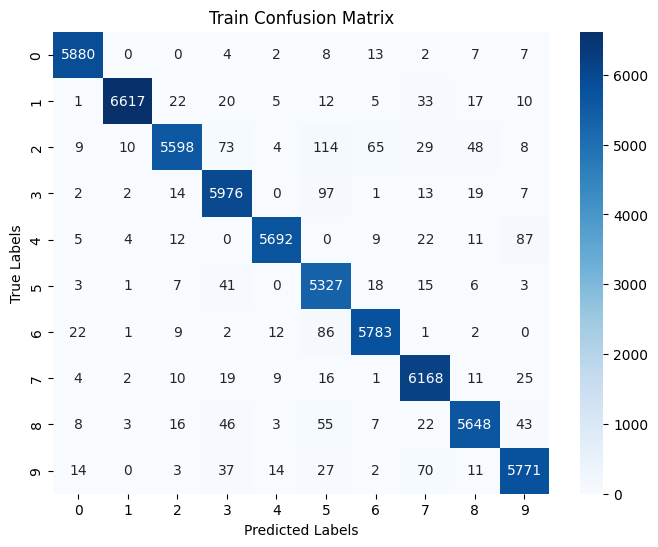


Train Classification Report:
               precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99      5923
     Class 1       1.00      0.98      0.99      6742
     Class 2       0.98      0.94      0.96      5958
     Class 3       0.96      0.97      0.97      6131
     Class 4       0.99      0.97      0.98      5842
     Class 5       0.93      0.98      0.95      5421
     Class 6       0.98      0.98      0.98      5918
     Class 7       0.97      0.98      0.98      6265
     Class 8       0.98      0.97      0.97      5851
     Class 9       0.97      0.97      0.97      5949

    accuracy                           0.97     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.97      0.97      0.97     60000


Test Confusion Matrix:
 [[ 965    0    1    2    2    4    2    1    1    2]
 [   0 1117    3    0    1    3    4    3    4    0]
 [   2    0  971   12    2   21   11    5    8    0]
 [   0    0    1  983    0

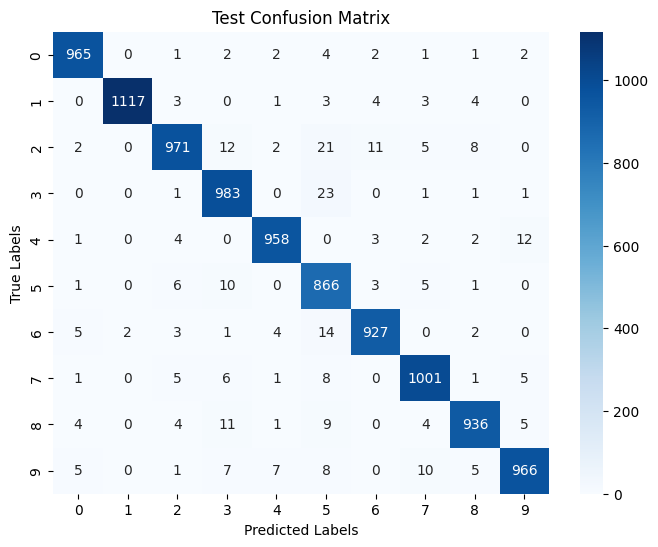


Test Classification Report:
               precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98       980
     Class 1       1.00      0.98      0.99      1135
     Class 2       0.97      0.94      0.96      1032
     Class 3       0.95      0.97      0.96      1010
     Class 4       0.98      0.98      0.98       982
     Class 5       0.91      0.97      0.94       892
     Class 6       0.98      0.97      0.97       958
     Class 7       0.97      0.97      0.97      1028
     Class 8       0.97      0.96      0.97       974
     Class 9       0.97      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_with_confusion_matrix(model, data_loader, dataset_type):
    model.eval()
    all_predictions = []  # Store all predictions
    all_labels = []       # Store all true labels
    
    with torch.no_grad():  # Disable gradient computation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.append(predicted.cpu())  # Move to CPU for sklearn
            all_labels.append(labels.cpu())

    # Concatenate predictions and true labels
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print(f"\n{dataset_type} Confusion Matrix:\n", cm)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"{dataset_type} Confusion Matrix")
    plt.show()

    # Classification Report
    report = classification_report(all_labels, all_predictions, target_names=[f"Class {i}" for i in range(10)])
    print(f"\n{dataset_type} Classification Report:\n", report)

# Call evaluation function
evaluate_with_confusion_matrix(model, train_loader, "Train")
evaluate_with_confusion_matrix(model, test_loader, "Test")


In [ ]:
#implementing the classification report without using the sklearn by using the formula 

In [32]:
import numpy as np

def calculate_metrics(cm):
    num_classes = cm.shape[0]
    precision = []
    recall = []
    f1_score = []

    for i in range(num_classes):
        TP = cm[i, i]  # True Positives
        FP = cm[:, i].sum() - TP  # False Positives
        FN = cm[i, :].sum() - TP  # False Negatives
        TN = cm.sum() - (TP + FP + FN)  # True Negatives

        # Precision, Recall, F1-Score
        precision_i = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall_i = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_i = 2 * (precision_i * recall_i) / (precision_i + recall_i) if (precision_i + recall_i) > 0 else 0

        precision.append(precision_i)
        recall.append(recall_i)
        f1_score.append(f1_i)

    # Average metrics
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    avg_f1_score = np.mean(f1_score)

    return precision, recall, f1_score, avg_precision, avg_recall, avg_f1_score

def evaluate_without_sklearn(model, data_loader, dataset_type):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.append(predicted.cpu())
            all_labels.append(labels.cpu())

    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print(f"\n{dataset_type} Confusion Matrix:\n", cm)

    # Calculate metrics
    precision, recall, f1_score, avg_precision, avg_recall, avg_f1 = calculate_metrics(cm)

    # Print detailed metrics
    print(f"\n{dataset_type} Classification Report (Without sklearn):")
    print(f"{'Class':<8}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}")
    for i in range(len(precision)):
        print(f"{i:<8}{precision[i]:<10.2f}{recall[i]:<10.2f}{f1_score[i]:<10.2f}")
    print(f"\nAverage Precision: {avg_precision:.2f}")
    print(f"Average Recall: {avg_recall:.2f}")
    print(f"Average F1-Score: {avg_f1:.2f}")

# Call evaluation function
evaluate_without_sklearn(model, train_loader, "Train")
evaluate_without_sklearn(model, test_loader, "Test")



Train Confusion Matrix:
 [[5879    0    2    2    3    7   12    1    9    8]
 [   1 6617   24   22    7   12    3   37   14    5]
 [  12   11 5602   72    5  121   61   31   38    5]
 [   1    2   13 5960    0  107    4   16   21    7]
 [   5    3    6    0 5688    1   10   25   16   88]
 [   5    1    6   35    0 5336   16   13    7    2]
 [  17    0   12    5   11   79 5788    0    6    0]
 [   2    2   14   16    8   15    0 6169   11   28]
 [   7    3   16   49    3   48    6   18 5655   46]
 [  15    2    5   34   14   31    3   62   12 5771]]

Train Classification Report (Without sklearn):
Class   Precision Recall    F1-Score  
0       0.99      0.99      0.99      
1       1.00      0.98      0.99      
2       0.98      0.94      0.96      
3       0.96      0.97      0.97      
4       0.99      0.97      0.98      
5       0.93      0.98      0.95      
6       0.98      0.98      0.98      
7       0.97      0.98      0.98      
8       0.98      0.97      0.97      
9    

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [34]:

# Load MNIST data
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0,), (128,)),
])
train = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=100)
testloader = torch.utils.data.DataLoader(test, shuffle=True, batch_size=100)


In [35]:

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.act1 = nn.Tanh()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.act2 = nn.Tanh()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)
        self.act3 = nn.Tanh()

        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(1*1*120, 84)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(84, 10)
        
    def forward(self, x):
        # input 1x28x28, output 6x28x28
        x = self.act1(self.conv1(x))
        # input 6x28x28, output 6x14x14
        x = self.pool1(x)
        # input 6x14x14, output 16x10x10
        x = self.act2(self.conv2(x))
        # input 16x10x10, output 16x5x5
        x = self.pool2(x)
        # input 16x5x5, output 120x1x1
        x = self.act3(self.conv3(x))
        # input 120x1x1, output 84
        x = self.act4(self.fc1(self.flat(x)))
        # input 84, output 10
        x = self.fc2(x)
        return x


In [38]:
model = LeNet5()  # Instantiate the LeNet-5 model

# why to use adam optimizer??
#--The Adam optimizer is often used because it combines the strengths of two other optimizers: Momentum-based Gradient Descent and RMSProp, making it highly efficient and adaptive.

optimizer = optim.Adam(model.parameters())  # Using the Adam optimizer for training
loss_fn = nn.CrossEntropyLoss()  # used for loss function in PyTorch primarily used for multi-class classification problems (measures the distance between the predicted probability distribution (output of a model) and the true class labels.)

n_epochs = 5
for epoch in range(n_epochs):

    # ---- Training Phase ----

    model.train()  # Set the model to training mode
    total_loss = 0  # Variable to accumulate the loss
    for X_batch, y_batch in trainloader:
        y_pred = model(X_batch)  # Forward pass: predict class probabilities
        loss = loss_fn(y_pred, y_batch)  # Compute the loss
        
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()  # Backpropagation: compute gradients
        optimizer.step()  # Update model parameters
        
        total_loss += loss.item()  # Accumulate loss (convert tensor to scalar)

    avg_loss = total_loss / len(trainloader)  # Calculate average loss per batch

    # ---- Validation Phase ----

    model.eval()  # Set the model to evaluation mode
    acc = 0  # Variable to track the total correct predictions
    count = 0  # Variable to count the total number of samples
    with torch.no_grad():  # Disable gradient computation during validation
        for X_batch, y_batch in testloader:
            y_pred = model(X_batch)  # Forward pass: compute predictions for the batch
            acc += (torch.argmax(y_pred, 1) == y_batch).float().sum()
            count += len(y_batch)  # Keep track of the total number of samples

    acc = acc / count  # Calculate accuracy as the ratio of correct predictions to total samples

    # Print the loss and accuracy for the current epoch
    print(f"Epoch {epoch+1}: Average Loss: {avg_loss:.4f}, Model Accuracy: {acc*100:.2f}%")


Epoch 1: Average Loss: 0.9675, Model Accuracy: 89.90%
Epoch 2: Average Loss: 0.2742, Model Accuracy: 93.13%
Epoch 3: Average Loss: 0.1967, Model Accuracy: 95.01%
Epoch 4: Average Loss: 0.1524, Model Accuracy: 96.05%
Epoch 5: Average Loss: 0.1263, Model Accuracy: 96.42%


Epoch 1/5, Train Loss: 0.3241, Test Loss: 0.1154, Accuracy: 96.53%
Epoch 2/5, Train Loss: 0.0981, Test Loss: 0.0694, Accuracy: 97.88%
Epoch 3/5, Train Loss: 0.0670, Test Loss: 0.0571, Accuracy: 98.18%
Epoch 4/5, Train Loss: 0.0509, Test Loss: 0.0573, Accuracy: 98.24%
Epoch 5/5, Train Loss: 0.0427, Test Loss: 0.0498, Accuracy: 98.42%


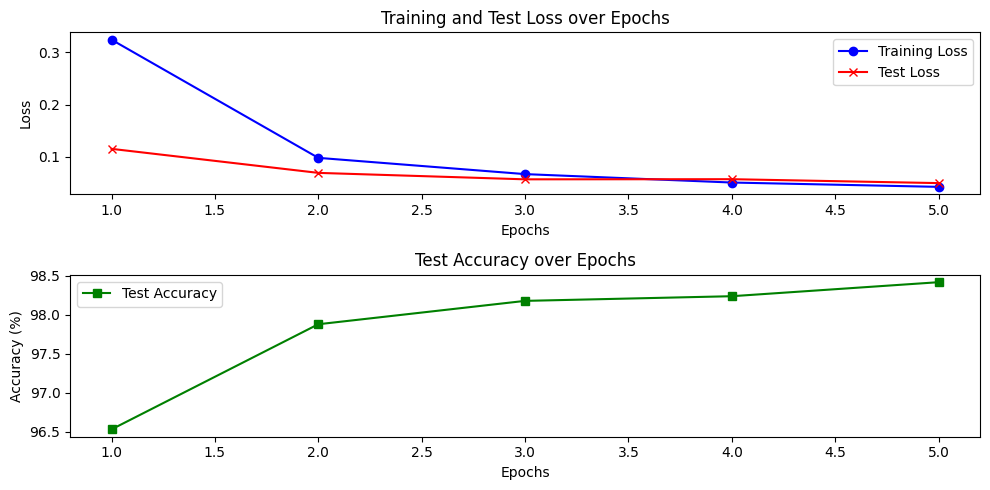

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

# Data Loading and Preprocessing
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)),
])
train = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=100)
testloader = torch.utils.data.DataLoader(test, shuffle=False, batch_size=100)

# Define LeNet5 Model
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.act1 = nn.Tanh()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.act2 = nn.Tanh()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)
        self.act3 = nn.Tanh()

        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120, 84)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.act3(self.conv3(x))
        x = self.act4(self.fc1(self.flat(x)))
        x = self.fc2(x)
        return x

# Initialize Model, Loss Function, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

# Lists to store metrics
train_losses = []
test_losses = []
test_accuracies = []

n_epochs = 5

# Training and Evaluation Loop
for epoch in range(n_epochs):
    # Training Phase
    model.train()
    train_loss = 0
    for X_batch, y_batch in trainloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss / len(trainloader))
    
    # Validation Phase
    model.eval()
    test_loss = 0
    correct = 0
    count = 0
    with torch.no_grad():
        for X_batch, y_batch in testloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            test_loss += loss_fn(y_pred, y_batch).item()
            correct += (torch.argmax(y_pred, 1) == y_batch).float().sum()
            count += len(y_batch)
    test_losses.append(test_loss / len(testloader))
    test_accuracies.append(correct / count)
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {test_accuracies[-1]*100:.2f}%")

# Plot Training and Test Loss
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(range(1, n_epochs+1), train_losses, 'b-o', label="Training Loss")
plt.plot(range(1, n_epochs+1), test_losses, 'r-x', label="Test Loss")
plt.title("Training and Test Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot Test Accuracy
plt.subplot(2, 1, 2)
plt.plot(range(1, n_epochs+1), [a.item()*100 for a in test_accuracies], 'g-s', label="Test Accuracy")
plt.title("Test Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()


In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [ ]:
# generating the confusion matrix and classification report for the LeNet5() model using sklearn 

In [42]:
# Collect all predictions and true labels
all_preds = []
all_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for X_batch, y_batch in testloader:
        y_pred = model(X_batch)
        all_preds.extend(torch.argmax(y_pred, 1).cpu().numpy())  # Predicted labels
        all_labels.extend(y_batch.cpu().numpy())  # True labels

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, digits=4)

# Print results
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Confusion Matrix:
 [[5856    0    5    0    8   13   22    0   11    8]
 [   1 6626   34   22    4    2   10    5   26   12]
 [  36   14 5785   12   19    8   28   10   37    9]
 [  20   14   58 5709    2  144    7   23  122   32]
 [   6    6   14    7 5547    4   47    8    7  196]
 [  13    4    6   32   11 5278   42    6   18   11]
 [  26    2    4    1    9   31 5834    0   11    0]
 [   3   19   87   21   24   15    3 5901   44  148]
 [  17   32   12   34    7   55   46    2 5620   26]
 [  18   12    4   37   85   24    2   40   34 5693]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9767    0.9887    0.9826      5923
           1     0.9847    0.9828    0.9837      6742
           2     0.9627    0.9710    0.9668      5958
           3     0.9717    0.9312    0.9510      6131
           4     0.9704    0.9495    0.9599      5842
           5     0.9469    0.9736    0.9601      5421
           6     0.9657    0.9858    0.9757   